<a id="title"></a>
# WFC3/UVIS Filter Transformations with stsynphot 
<hr>
## Learning Goals

By the end of this tutorial, you will:
- Generate synthetic observations using `synphot` and `stsynphot`.
- Find color terms between WFC3/UVIS filters and non-HST filters.
- Plot bandpasses to investigate various throughputs.


## Table of Contents

[Introduction](#intro) <br>
[1. Imports](#imports) <br>
[2. Select filters for the transformation](#select) <br>
[3. Define a spectrum](#spec) <br>
[4. Select UVIS chips](#chips) <br>
[5. Select magnitude systems](#system) <br>
[6. Generate outputs](#output) <br>
[7. Plot bandpasses](#band) <br>
[8. Conclusions](#conclusion) <br>
[Additional Resources](#resources) <br>
[About the Notebook](#about) <br>
[Citations](#cite) <br>

<a id="intro"></a>
## Introduction
This notebook computes color terms between selected WFC3/UVIS filters and non-HST filters, such as Johnson-Cousins, for a user-defined reference spectrum. The terms as given are the difference between the magnitude of the spectrum in the selected non-HST filter and the corresponding UVIS filter. 

This tool reproduces the methods described in section 4 of [WFC3 ISR 2014-16](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2014/WFC3-2014-16.pdf), but will automatically use the latest available spectra and throughput tables.

`stsynphot` requires access to data distributed by the [Calibration Data Reference System](https://hst-crds.stsci.edu/) (CRDS) in order to operate. Both packages look for an environment variable called `PYSYN_CDBS` to find the directory containing these data.

Users can obtain these data files from the CDRS. Information on how to obtain the most up-to-date reference files (and what they contain) can be found [here](https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/synphot-throughput-tables). An example of how to download the files with `curl` and set up this environment variable is presented below.

For detailed instructions on how to install and set up these packages, see the [synphot](https://synphot.readthedocs.io/en/latest/#installation-and-setup) and [stsynphot](https://stsynphot.readthedocs.io/en/latest/#installation-and-setup) documentation.

<a id="imports"></a>
## 1. Imports

This notebook assumes you have created the virtual environment in [WFC3 notebooks'](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/WFC3/README.md) installation instructions.

We import:

- *os* for setting environment variables
- *tarfile* for extracting a .tar archive
- *numpy* for handling array functions
- *pandas* for managing data
- *matplotlib.pyplot* for plotting data
- *astropy.units* and *synphot.units* for handling units
- *synphot* and *stsynphot* for evaluating synthetic photometry

Additionally, we will need to set the `PYSYN_CDBS` environment variable *before* importing stsynphot. We will also create a Vega spectrum using synphot's inbuilt `from_vega()` method, as the latter package will supercede this method's functionality and require a downloaded copy of the latest Vega spectrum to be provided.

In [1]:
import os
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
import synphot.units as su
import synphot as syn
from synphot import Observation

%matplotlib inline

vegaspec = syn.SourceSpectrum.from_vega()

This section obtains the WFC3 throughput component tables for use with `stsynphot`. This step only needs to be done once. If these reference files have already been downloaded, this section can be skipped.

In [2]:
!curl -O https://archive.stsci.edu/hlsps/reference-atlases/hlsp_reference-atlases_hst_multi_everything_multi_v11_sed.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0  796M    0 98304    0     0   323k      0  0:42:02 --:--:--  0:42:02  323k

  7  796M    7 60.2M    0     0  46.4M      0  0:00:17  0:00:01  0:00:16 46.4M

  9  796M    9 78.1M    0     0  34.0M      0  0:00:23  0:00:02  0:00:21 34.0M

 11  796M   11 90.2M    0     0  27.4M      0  0:00:29  0:00:03  0:00:26 27.4M

 13  796M   13  106M    0     0  24.7M      0  0:00:32  0:00:04  0:00:28 24.7M

 15  796M   15  121M    0     0  22.8M      0  0:00:34  0:00:05  0:00:29 24.1M

 17  796M   17  142M    0     0  22.6M      0  0:00:35  0:00:06  0:00:29 16.4M

 20  796M   20  160M    0     0  22.0M      0  0:00:36  0:00:07  0:00:29 16.4M

 22  796M   22  183M    0     0  22.0M      0  0:00:36  0:00:08  0:00:28 18.5M

 25  796M   25  201M    0     0  21.7M      0  0:00:36  0:00:09  0:00:27 19.1M

 27  796M   27  222M    0     0  21.5M      0  0:00:36  0:00:10  0:00:26 20.2M

 30  796M   30  244M    0     0  21.6M      0  0:00:36  0:00:11  0:00:25 20.3M

 32  796M   32  259M    0     0  21.1M      0  0:00:37  0:00:12  0:00:25 19.8M

 34  796M   34  277M    0     0  20.8M      0  0:00:38  0:00:13  0:00:25 18.8M

 37  796M   37  295M    0     0  20.6M      0  0:00:38  0:00:14  0:00:24 18.7M

 39  796M   39  312M    0     0  20.4M      0  0:00:38  0:00:15  0:00:23 17.9M

 41  796M   41  327M    0     0  20.0M      0  0:00:39  0:00:16  0:00:23 16.6M

 43  796M   43  347M    0     0  20.0M      0  0:00:39  0:00:17  0:00:22 17.5M

 45  796M   45  364M    0     0  19.9M      0  0:00:39  0:00:18  0:00:21 17.4M

 47  796M   47  381M    0     0  19.7M      0  0:00:40  0:00:19  0:00:21 17.2M

 51  796M   51  408M    0     0  20.1M      0  0:00:39  0:00:20  0:00:19 19.2M

 54  796M   54  435M    0     0  20.4M      0  0:00:38  0:00:21  0:00:17 21.7M

 57  796M   57  458M    0     0  20.5M      0  0:00:38  0:00:22  0:00:16 22.3M

 59  796M   59  472M    0     0  20.2M      0  0:00:39  0:00:23  0:00:16 21.5M

 61  796M   61  488M    0     0  20.1M      0  0:00:39  0:00:24  0:00:15 21.3M

 64  796M   64  509M    0     0  20.1M      0  0:00:39  0:00:25  0:00:14 20.2M

 66  796M   66  532M    0     0  20.2M      0  0:00:39  0:00:26  0:00:13 19.3M

 69  796M   69  550M    0     0  20.1M      0  0:00:39  0:00:27  0:00:12 18.3M

 71  796M   71  572M    0     0  20.2M      0  0:00:39  0:00:28  0:00:11 20.0M

 75  796M   75  597M    0     0  20.3M      0  0:00:39  0:00:29  0:00:10 21.7M

 78  796M   78  625M    0     0  20.6M      0  0:00:38  0:00:30  0:00:08 23.1M

 81  796M   81  651M    0     0  20.8M      0  0:00:38  0:00:31  0:00:07 23.8M

 85  796M   85  676M    0     0  20.9M      0  0:00:37  0:00:32  0:00:05 25.2M

 87  796M   87  700M    0     0  21.0M      0  0:00:37  0:00:33  0:00:04 25.6M

 89  796M   89  716M    0     0  20.8M      0  0:00:38  0:00:34  0:00:04 23.8M

 91  796M   91  732M    0     0  20.7M      0  0:00:38  0:00:35  0:00:03 21.3M

 93  796M   93  748M    0     0  20.6M      0  0:00:38  0:00:36  0:00:02 19.2M

 96  796M   96  768M    0     0  20.6M      0  0:00:38  0:00:37  0:00:01 18.3M

 98  796M   98  787M    0     0  20.5M      0  0:00:38  0:00:38 --:--:-- 17.3M

100  796M  100  796M    0     0  20.5M      0  0:00:38  0:00:38 --:--:-- 18.0M


Once the downloaded is complete, extract the file and set the environment variable `PYSYN_CDBS` to the path of the `trds` subdirectory.  The next cell will do this for you, as long as the `.tar` file downloaded above has not been moved.

In [3]:
tar_archive = 'hlsp_reference-atlases_hst_multi_everything_multi_v11_sed.tar'
extract_to = 'hlsp_reference-atlases_hst_multi_everything_multi_v11_sed'
abs_extract_to = os.path.abspath(extract_to)

with tarfile.open(tar_archive, 'r') as tar:
    for member in tar.getmembers():
        member_path = os.path.abspath(os.path.join(abs_extract_to, member.name))
        if member_path.startswith(abs_extract_to):
            tar.extract(member, path=extract_to)   
        else:
            print(f"Skipped {member.name} due to potential security risk")

os.environ['PYSYN_CDBS'] = os.path.join(abs_extract_to, 'grp/redcat/trds/')

Now, after having set up `PYSYN_CDBS`, we import stsynphot. A warning regarding the Vega spectrum is expected here.

In [4]:
import stsynphot as stsyn

<a id="select"></a>
## 2. Select filters for the transformation

Define the filters to use for computing the transformation. One filter should be a UVIS filter, and the other a non-HST filter such as a Johnson-Cousins filter.

**Filter names should be input as a list of tupled strings. Each tuple represents a pair of filters to convert between, and should contain the non-HST filter as the first element, and the UVIS filter as the second.**

For non-HST filters, the filter system be included in the string, separated from the filter name by a comma (e.g. `'johnson, v'` or `'sdss, g'`). The available non-HST filters are listed here:

| System    | Bands               |
|:----------|:--------------------|
| cousins   | r, i                |
| galex     | nuv, fuv            |
| johnson   | u, b, v, r, i, j, k |
| landolt   | u, b, v, r, i       |
| sdss      | u, g, r, i, z,      |
| stromgren | u, v, b, y          |

Furthermore, Johnson-Cousins filters with corresponding UVIS filters are listed here:

| Johnson-Cousins Filter 	| UVIS Filter 	|
|:------------------------	|:-------------	|
| U                      	| F336W       	|
| B                      	| F475W       	|
| V                      	| F555W/F606W 	|
| I                      	| F814W       	|

A summary of the UVIS filters, with descriptions, is available in [Section 6.5.1](https://hst-docs.stsci.edu/wfc3ihb/chapter-6-uvis-imaging-with-wfc3/6-5-uvis-spectral-elements#id-6.5UVISSpectralElements-6.5.1FilterandGrismSummary) of the WFC3 Instrument Handbook

The notebook is currently set up to return the color terms between the V and I Johnson-Cousins filters, and corresponding UVIS filters.

In [5]:
filter_pairs = [('johnson, v', 'f555w'), ('cousins, i', 'f814w')]

<a id="spec"></a>
## 3. Define a spectrum

Define a spectrum to get color terms for. Some common options are embedded below. A wide array of reference spectra are available for download from spectral atlases located [here](https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/astronomical-catalogs).

```python
# Blackbody (5000 K)
blackbody_temperature = 5000

model = syn.models.BlackBody1D(blackbody_temperature)
source_spectrum  = syn.SourceSpectrum(model)

# Power law 
pl_index = 0

model = syn.models.PowerLawFlux1D(amplitude=flux_in, x_0=wl_in, alpha=pl_index)
source_spectrum  = syn.SourceSpectrum(model)
                   
# Load from a FITS table (e.g. a CALSPEC spectrum)
source_spectrum = syn.SourceSpectrum.from_file('/path/to/your/spectrum.fits')
```
Currently, the notebook is configured to use a 5000 K blackbody spectrum.

In [6]:
blackbody_temperature = 5000

model = syn.models.BlackBody1D(blackbody_temperature)
source_spectrum = syn.SourceSpectrum(model)

<a id="chips"></a>
## 4. Select UVIS chips

Quantum efficiency differences between the two UVIS chips mean that you must specify which chips to use for computing color terms. Simply set the chip you would like to use to `True` and the other to `False`, or set both to `True` if you would like coefficients for both.

In [7]:
use_uvis1 = True
use_uvis2 = True
chips = [use_uvis1, use_uvis2]

<a id="system"></a>
## 5. Select magnitude systems

Select which magnitude systems you would like color terms to be provided for. Set those you would like to `True` and others to `False`.

In [8]:
ABMAG = True
STMAG = True
VEGAMAG = False

mags = [('ABMAG', u.ABmag, ABMAG), ('STMAG', u.STmag, STMAG),
        ('VEGAMAG', su.VEGAMAG, VEGAMAG)]

<a id="output"></a>
## 6. Generate outputs

Generate a data frame containing the color terms for the inputs you have specified. 

First, let's define the column names for the output table, and a list to fill with table rows.

In [9]:
cols = ['Filter Pair', 'Chip']
rows = []

Then, append the names of magnitude systems being used.

In [10]:
for name, _, toggle in mags:
    if toggle:
        cols.append(f'{name} Color Term')

Next, iterate over filter pairs. For each filter pair, this loop will:
- generate observation mode strings, bandpasses, and observations
- calculate the color term and append it
- append filters, chip, and color term as a row to `rows`

In [11]:
for pair in filter_pairs:
    comparison_filter, uvis_filter = pair  # Unpack filters
    filt_str = comparison_filter + ' - ' + uvis_filter

    for i, toggle in enumerate(chips):
        if not toggle:
            continue
        chip_str = 'UVIS' + str(i + 1)

        # Generate observation mode strings, bandpasses, observations
        comparison_obsmode = comparison_filter
        uvis_obsmode = 'wfc3, ' + chip_str + ', ' + uvis_filter

        comparison_bp = stsyn.band(comparison_obsmode)
        uvis_bp = stsyn.band(uvis_obsmode)

        comparison_observation = Observation(source_spectrum, comparison_bp)
        uvis_observation = Observation(source_spectrum, uvis_bp)
        row = [filt_str, chip_str]  # Append filters and chip to row

        for name, unit, toggle in mags:
            if not toggle:
                continue
            comparison_countrate = comparison_observation.effstim(
                flux_unit=unit, vegaspec=vegaspec)
            uvis_countrate = uvis_observation.effstim(
                flux_unit=unit, vegaspec=vegaspec)
            color = comparison_countrate - uvis_countrate  # Find color term
            row.append(f'{color.value:.3f}')  # Append color term

        rows.append(row)  # Append row to list of rows

Finally, generate and return the output table.

In [12]:
df = pd.DataFrame(rows, columns=cols)
df

,Filter Pair,Chip,ABMAG Color Term,STMAG Color Term
0,"johnson, v - f555w",UVIS1,-0.094,-0.025
1,"johnson, v - f555w",UVIS2,-0.094,-0.025
2,"cousins, i - f814w",UVIS1,0.005,-0.039
3,"cousins, i - f814w",UVIS2,0.005,-0.038


If you wish to save the output table as a .txt file, please uncomment and execute the code block below.

In [13]:
# df.to_csv('your/path/here.txt', sep='\t')

<a id="band"></a>
## 7. Plot bandpasses

It can be nice to see your selected bandpass pairs plotted with each other. The cell below will generate a figure with subplots for each filter pair specified above, as well as the relevant portion of the spectrum you've defined, all normalized to fit on the same axes.

**Note:** For the purposes of these plots, the non-HST bandpass and spectrum have been scaled to the amplitude of the HST bandpass, which reflects the actual total system throughput as a function of wavelength.

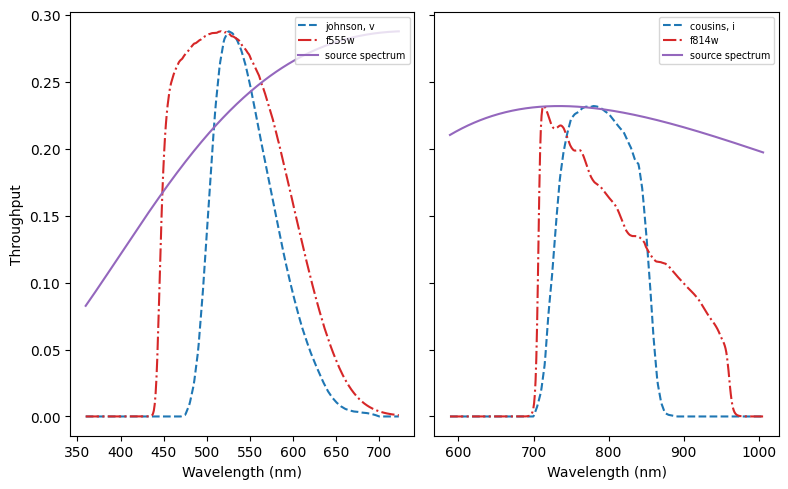

In [14]:
fig, axs = plt.subplots(1, len(filter_pairs), sharey=True, figsize=(
    4*len(filter_pairs), 5))  # Instantiate subplots
axs[0].set_ylabel('Throughput')
for i, pair in enumerate(filter_pairs):

    f1, f2 = pair
    bp1 = stsyn.band(f1)
    bp2 = stsyn.band('wfc3, uvis1,' + f2)

    # Create wavelength array for subplot based on average bandpass wavelength and width
    avgwave = (bp1.avgwave().to(u.nm) + bp2.avgwave().to(u.nm))/2
    width = (bp1.rectwidth().to(u.nm) + bp2.rectwidth().to(u.nm))/2
    left = max((avgwave - 1.5 * width).value, 1)
    right = (avgwave + 1.5 * width).value

    wl = np.arange(left, right) * u.nm

    # Normalize curves to fit on one set of axes
    bp1_norm = bp1(wl) / np.max(bp1(wl)) * np.max(bp2(wl))
    spec_norm = source_spectrum(
        wl) / np.max(source_spectrum(wl)) * np.max(bp2(wl))

    # Plot bandpasses and spectrum on subplot
    axs[i].plot(wl, bp1_norm, ls='--', label=f1, c='tab:blue')
    axs[i].plot(wl, bp2(wl),  ls='-.', label=f2, c='tab:red')
    axs[i].plot(wl, spec_norm, label='source spectrum', c='tab:purple')
    axs[i].set_xlabel('Wavelength (nm)')
    axs[i].legend(fontsize='x-small', loc='upper right')
plt.tight_layout()

<a id="conclusion"></a>
## 8. Conclusions

Thank you for walking through this notebook. Now using WFC3 data, you should be more familiar with:

- Generating synthetic observations using `synphot` and `stsynphot`.
- Finding color terms between WFC3/UVIS filters and non-HST filters.
- Ploting bandpasses to investigate various throughputs.

#### Congratulations, you have completed the notebook!

<a id="resources"></a>
## Additional Resources
Below are some additional resources that may be helpful. Please send any questions through the [HST Helpdesk](https://stsci.service-now.com/hst).

- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)
    - see sections 9.5.2 for reference to this notebook
    
<a id="about"></a>
## About this Notebook

**Authors:** Aidan Pidgeon, Jennifer Mack; WFC3 Instrument Team

**Updated on:** 2021-09-13

<a id="cite"></a>
## Citations

If you use `numpy`, `astropy`, `synphot`, or `stsynphot` for published research, please cite the
authors. Follow these links for more information about citing the libraries below:

* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `synphot`](https://synphot.readthedocs.io/en/latest/)
* [Citing `stsynphot`](https://stsynphot.readthedocs.io/en/latest/index.html)

<hr>

[Top of Page](#title)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/hst_notebooks/main/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 